<h1>Analýza covidu</h1>

In [1]:
from CoronaAI import *
from Models import *

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
corona = CoronaAI()

In [3]:
corona.load_dataset("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv")

c:\users\hseve\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173472 entries, 0 to 173471
Data columns (total 13 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   CountryName                           173472 non-null  object        
 1   RegionName                            70056 non-null   object        
 2   Date                                  173472 non-null  datetime64[ns]
 3   C1_School closing                     168667 non-null  float64       
 4   C2_Workplace closing                  168612 non-null  float64       
 5   C3_Cancel public events               168687 non-null  float64       
 6   C4_Restrictions on gatherings         168638 non-null  float64       
 7   C5_Close public transport             168620 non-null  float64       
 8   C6_Stay at home requirements          168561 non-null  float64       
 9   C7_Restrictions on internal movement  168582 non-null  floa

In [4]:
corona.country_data("Czech Republic")

C1_School closing  C2_Workplace closing  C3_Cancel public events  \
Date                                                                           
2020-01-23                0.0                   0.0                      0.0   
2020-01-24                0.0                   0.0                      0.0   
2020-01-25                0.0                   0.0                      0.0   
2020-01-26                0.0                   0.0                      0.0   
2020-01-27                0.0                   0.0                      0.0   
...                       ...                   ...                      ...   
2021-06-09                1.0                   2.0                      2.0   
2021-06-10                1.0                   2.0                      2.0   
2021-06-11                1.0                   2.0                      2.0   
2021-06-12                1.0                   2.0                      2.0   
2021-06-13                1.0                   2.0                      2.0   

            C4_Restrictions on gatherings  C5_Close public transport  \
Date                                                                   
2020-01-23                            0.0                        0.0   
2020-01-24                            0.0                        0.0   
2020-01-25                            0.0                        0.0   
2020-01-26                            0.0                        0.0   
2020-01-27                            0.0                        0.0   
...                                   ...                        ...   
2021-06-09                            2.0                        0.0   
2021-06-10                            2.0                        0.0   
2021-06-11                            2.0                        0.0   
2021-06-12                            2.0                        0.0   
2021-06-13                            2.0                        0.0   

            C6_Stay at home requirements  \
Date                                       
2020-01-23                           0.0   
2020-01-24                           0.0   
2020-01-25                           0.0   
2020-01-26                           0.0   
2020-01-27                           0.0   
...                                  ...   
2021-06-09                           0.0   
2021-06-10                           0.0   
2021-06-11                           0.0   
2021-06-12                           0.0   
2021-06-13                           0.0   

            C7_Restrictions on internal movement  \
Date                                               
2020-01-23                                   0.0   
2020-01-24                                   0.0   
2020-01-25                                   0.0   
2020-01-26                                   0.0   
2020-01-27                                   0.0   
...                                          ...   
2021-06-09                                   0.0   
2021-06-10                                   0.0   
2021-06-11                                   0.0   
2021-06-12                                   0.0   
2021-06-13                                   0.0   

            C8_International travel controls  NewCases  NewDeaths  
Date                                                               
2020-01-23                               0.0       0.0        0.0  
2020-01-24                               0.0       0.0        0.0  
2020-01-25                               0.0       0.0        0.0  
2020-01-26                               0.0       0.0        0.0  
2020-01-27                               1.0       0.0        0.0  
...                                      ...       ...        ...  
2021-06-09                               3.0     384.0        9.0  
2021-06-10                               3.0     267.0        9.0  
2021-06-11                               3.0     190.0        8.0  
2021-06-12                          

In [5]:
# corona.country_data("Venezuela")

In [6]:
corona.build_generators(["Czech Republic"])
corona.build_generators(["United States"])
# corona.build_generators(["Czech Republic", "United States"])
# corona.build_generators(["Venezuela"])

<h2>Singlestep</h2>

In [7]:
baseline = Baseline()
corona.register_model("Baseline", baseline, WindowGenerator.single_step_window)

In [8]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=corona.num_features)
])
corona.register_model("Linear", linear, WindowGenerator.single_step_window)

In [9]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=corona.num_features)
])
corona.register_model("Dense", dense, WindowGenerator.single_step_window)

In [10]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=corona.num_features),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])
corona.register_model("Multistep dense", multi_step_dense, WindowGenerator.conv_window)

In [11]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=corona.num_features),
])
corona.register_model("Convulation", conv_model, WindowGenerator.conv_window)

In [12]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=corona.num_features)
])
corona.register_model("LSTM", lstm_model, WindowGenerator.wide_window)

In [13]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        corona.num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros())
]))
corona.register_model("Residual LSTM", residual_lstm, WindowGenerator.wide_window)

<h2>Multistep</h2>

In [14]:
last_baseline = MultiStepLastBaseline(OUT_STEPS) 
corona.register_model("Multi Last", last_baseline, WindowGenerator.multi_window)

In [15]:
repeat_baseline = RepeatBaseline(OUT_STEPS)
corona.register_model("Multi Repeat", repeat_baseline, WindowGenerator.multi_window)

In [16]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*corona.num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, corona.num_features])
])
corona.register_model("Multi Linear", multi_linear_model, WindowGenerator.multi_window)

In [17]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*corona.num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, corona.num_features])
])
corona.register_model("Multi Dense", multi_dense_model, WindowGenerator.multi_window)

In [18]:
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*corona.num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, corona.num_features])
])
corona.register_model("Multi Convu", multi_conv_model, WindowGenerator.multi_window)

In [19]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*corona.num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, corona.num_features])
])
corona.register_model("Multi LSTM", multi_lstm_model, WindowGenerator.multi_window)

In [20]:
residual_lstm_model = ResidualWrapper(
    tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units]
        # Adding more `lstm_units` just overfits more quickly.
        tf.keras.layers.LSTM(32, return_sequences=False),
        
        # Shape => [batch, out_steps*features]
        tf.keras.layers.Dense(OUT_STEPS*corona.num_features,
                              kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, corona.num_features])
    ])
)
corona.register_model("Multi Residual LSTM", residual_lstm_model, WindowGenerator.multi_window)

In [21]:
feedback_model = FeedBack(units=32, num_features= corona.num_features, out_steps=OUT_STEPS, )
corona.register_model("Feedback", feedback_model, WindowGenerator.multi_window)

Input shape (batch, time, features): (32, 24, 10)
Output shape (batch, time, features): (32, 24, 10)
2/2 [==============================] - 0s 4ms/step - loss: 3180530688.0000 - mean_absolute_error: 17000.1738 - root_mean_squared_error: 56396.1953
None
NewDeaths
Baseline                 : 977.7580 (MAE), 3975.5388 (RMSE)
Linear                   : 1002.1012 (MAE), 3989.4443 (RMSE)
Dense                    : 1025.8485 (MAE), 4017.7598 (RMSE)
Multistep dense          : 1184.0491 (MAE), 3814.8958 (RMSE)
Convulation              : 1175.6954 (MAE), 3862.4739 (RMSE)
LSTM                     : 5041.7549 (MAE), 16933.0273 (RMSE)
Residual LSTM            : 1058.1873 (MAE), 4265.7412 (RMSE)
Multi Last               : 1706.7318 (MAE), 6418.0547 (RMSE)
Multi Repeat             : 2423.5388 (MAE), 8686.5039 (RMSE)
Multi Linear             : 1423.6522 (MAE), 5360.3740 (RMSE)
Multi Dense              : 2364.5212 (MAE), 8328.6152 (RMSE)
Multi Convu              : 2553.1946 (MAE), 8907.9512 (RMSE)
Multi

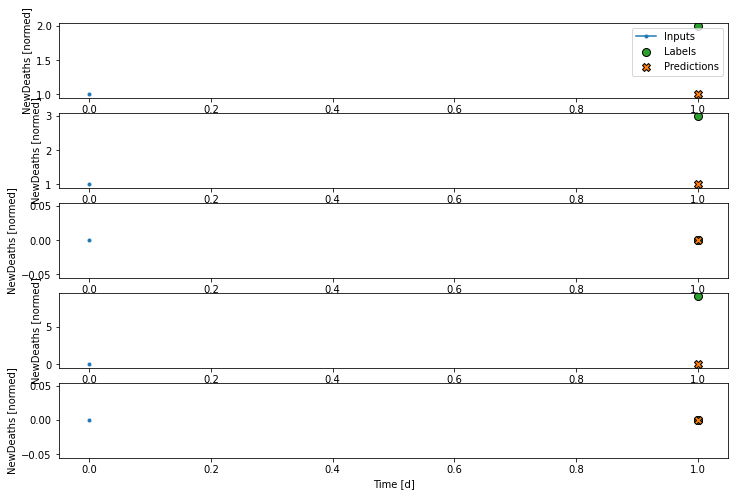

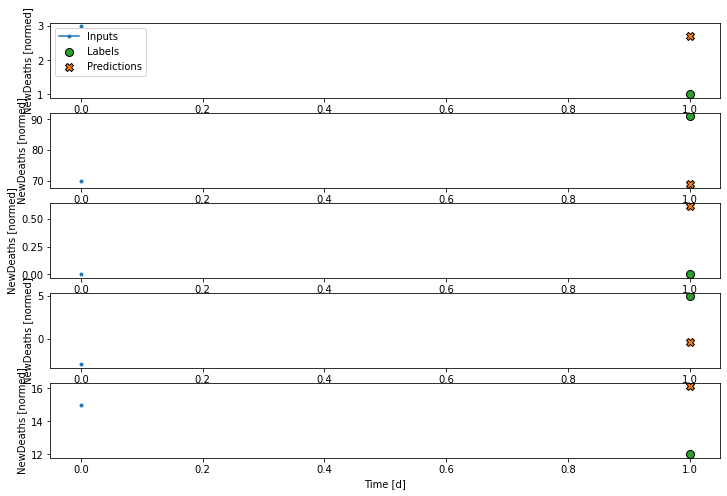

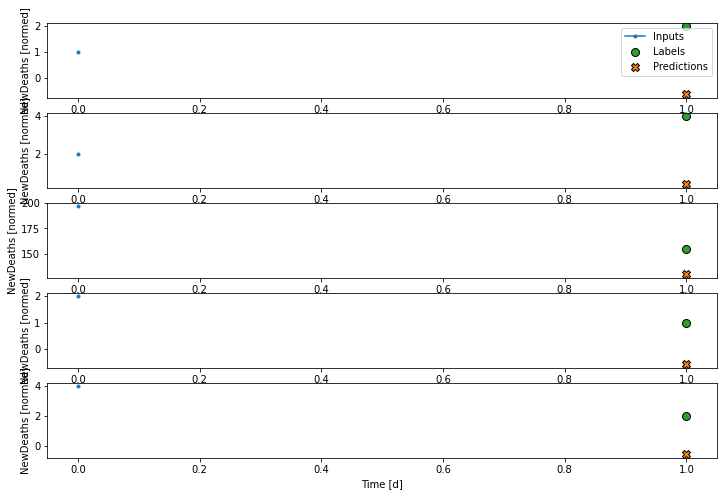

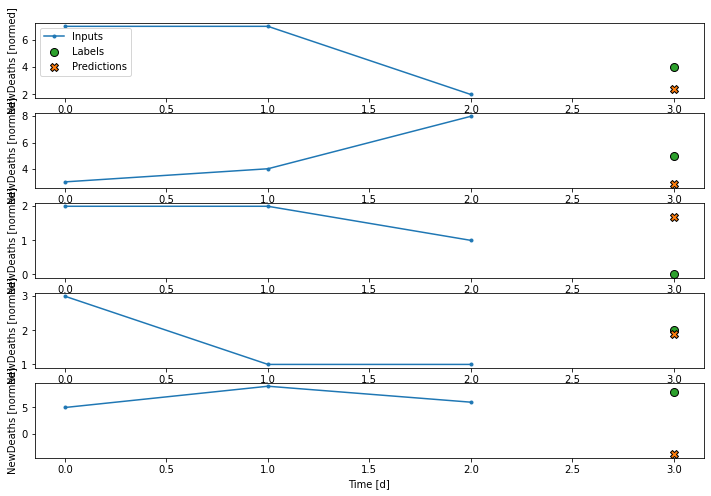

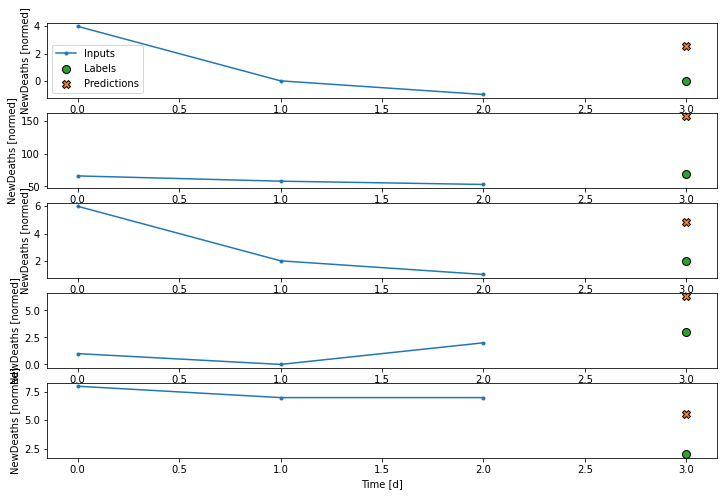

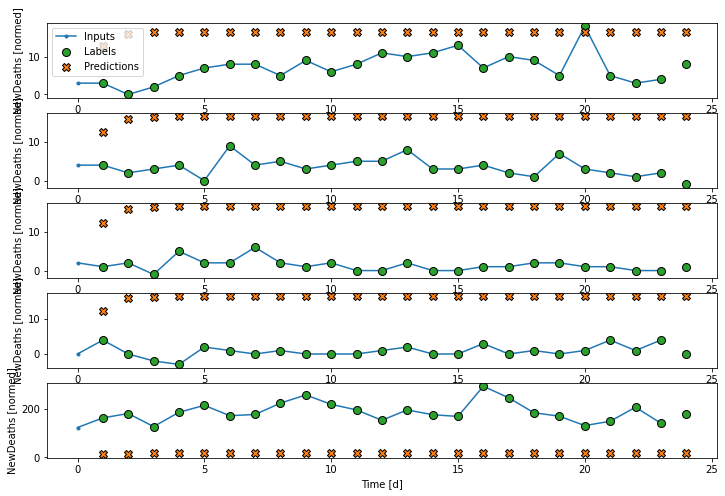

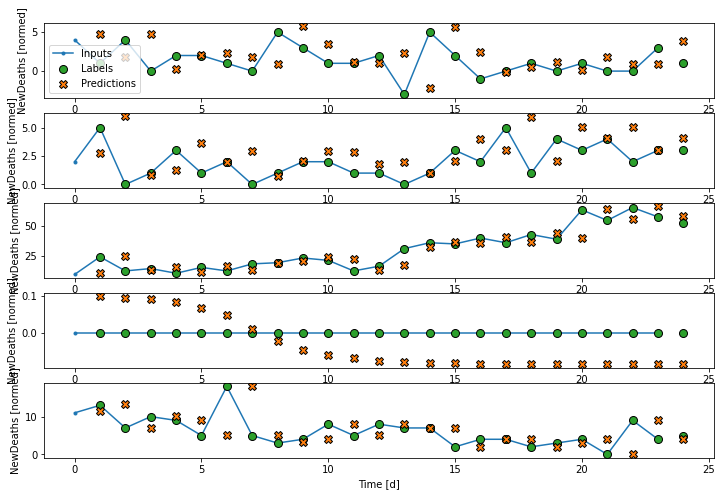

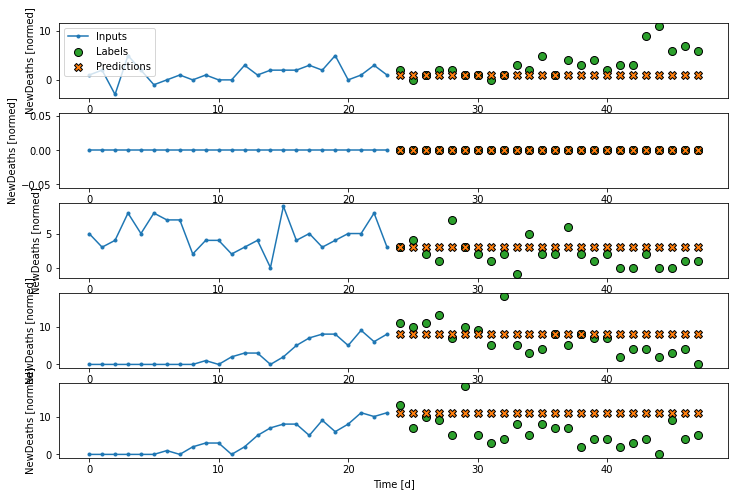

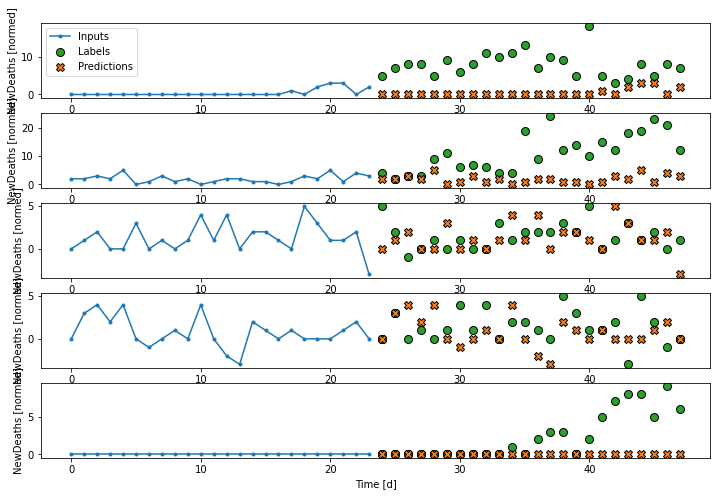

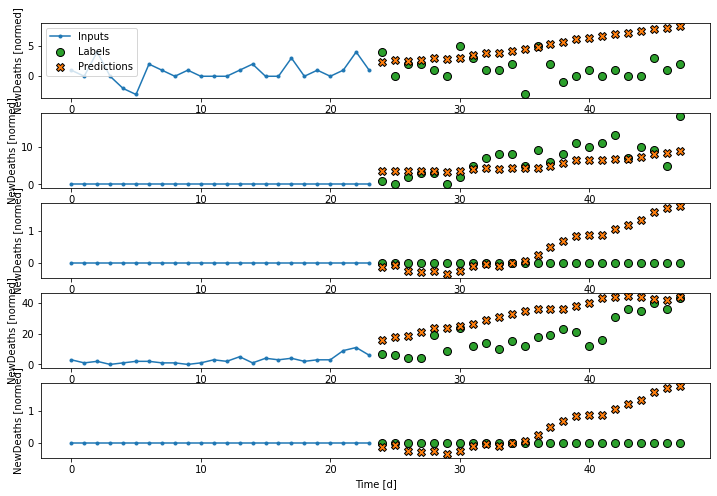

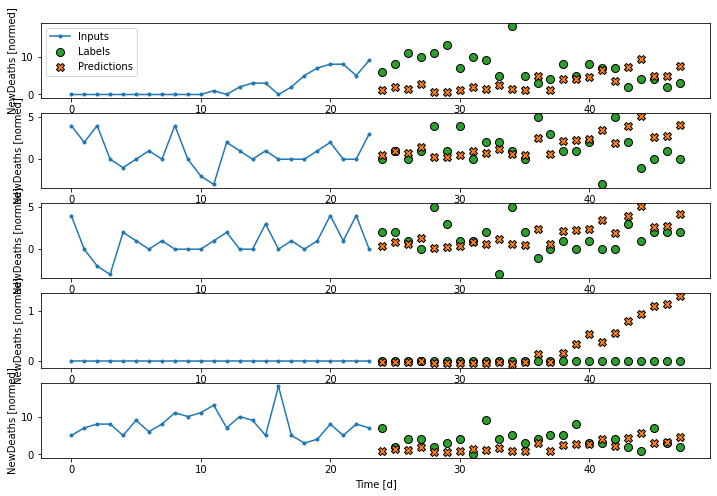

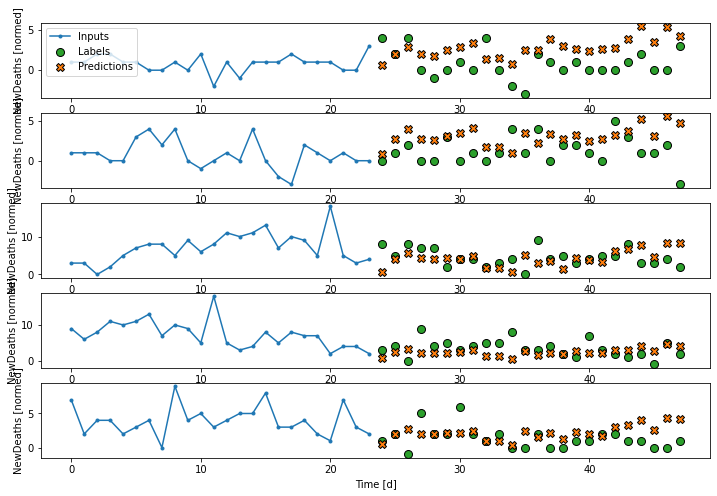

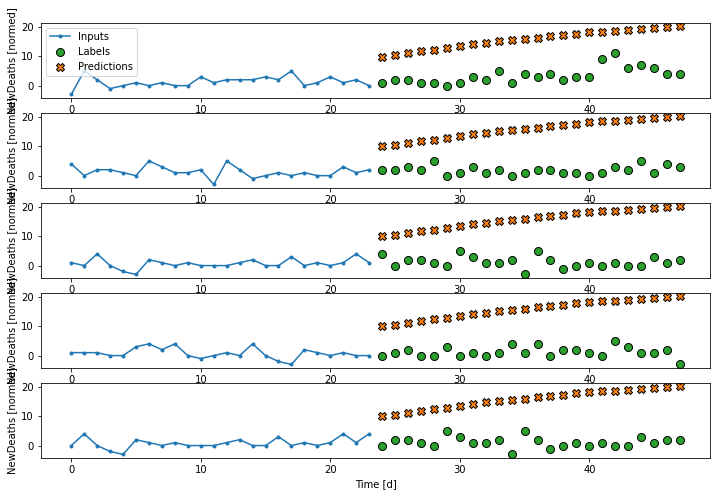

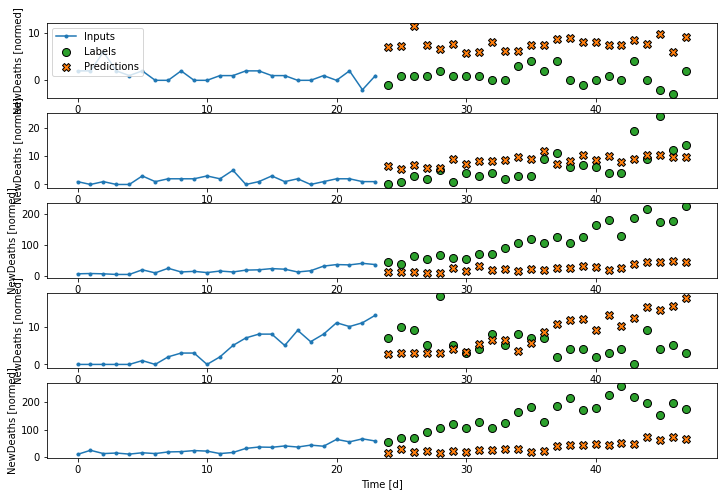

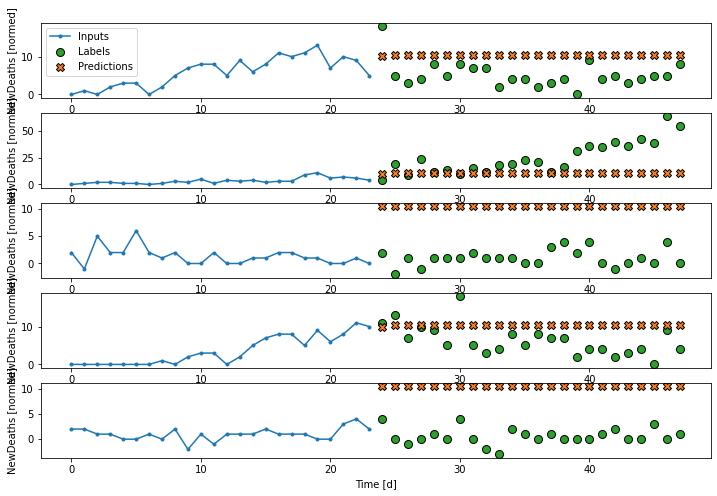

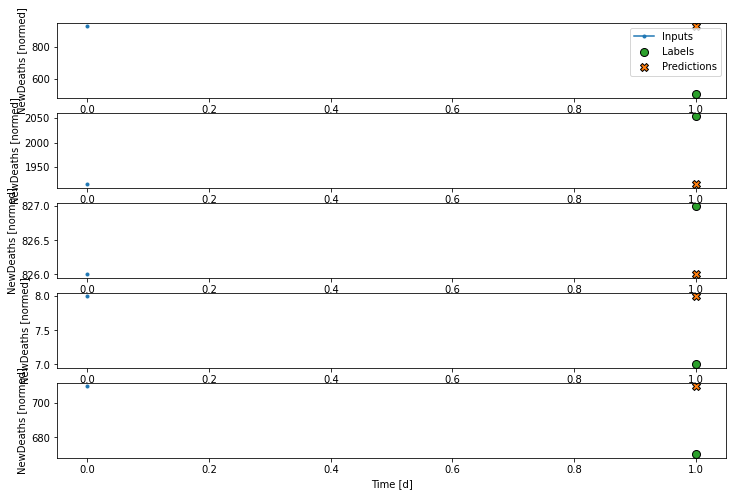

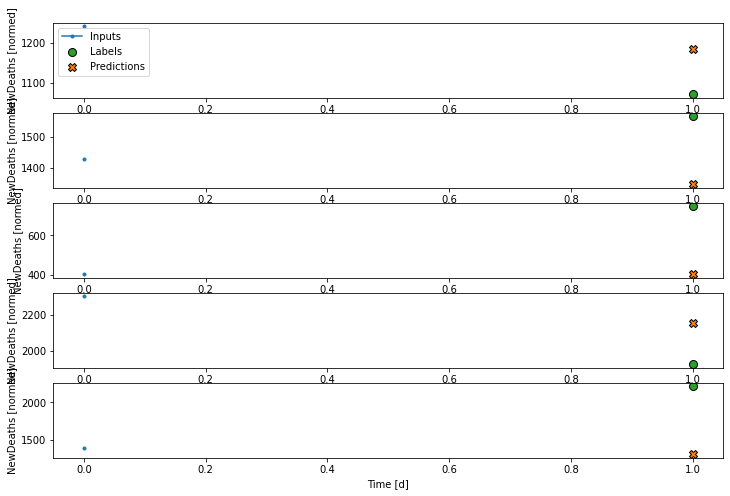

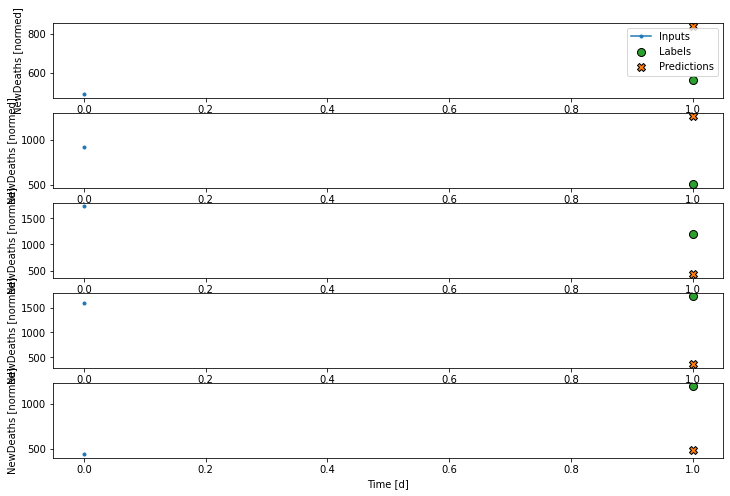

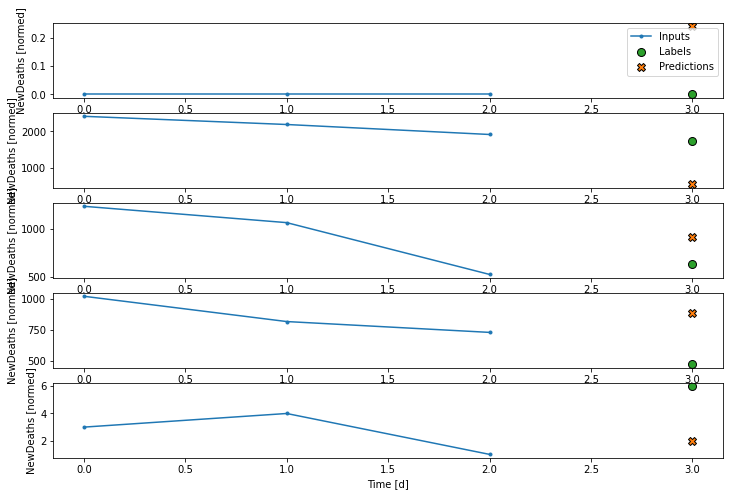

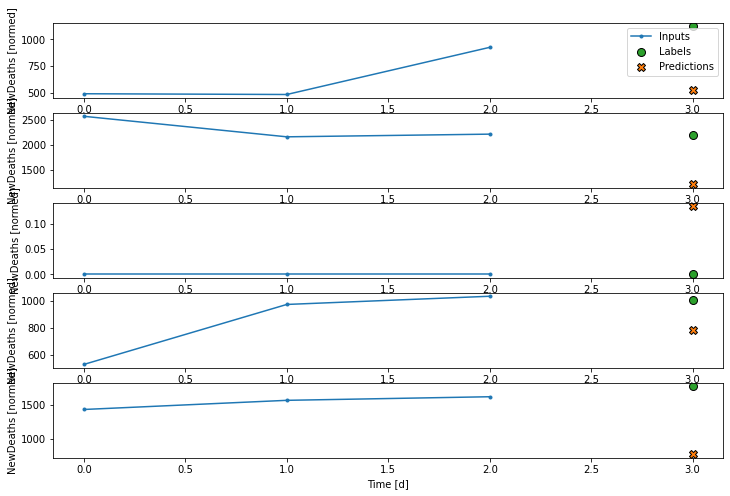

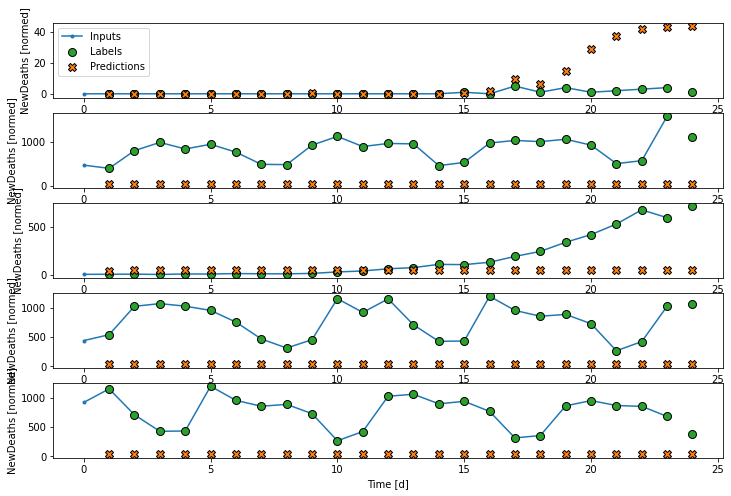

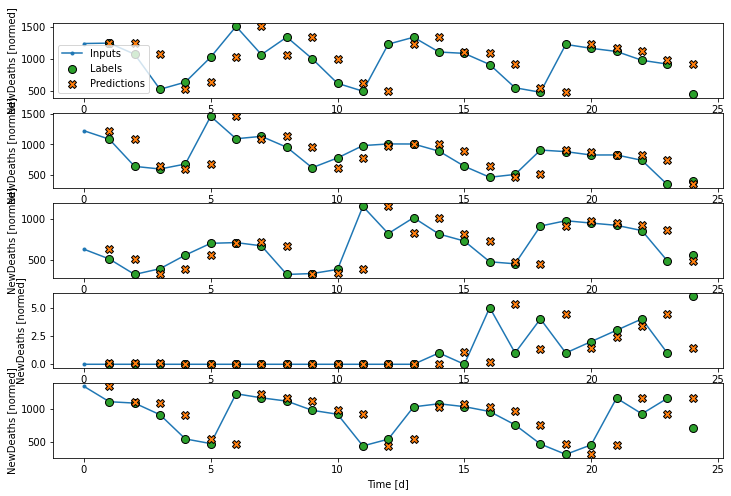

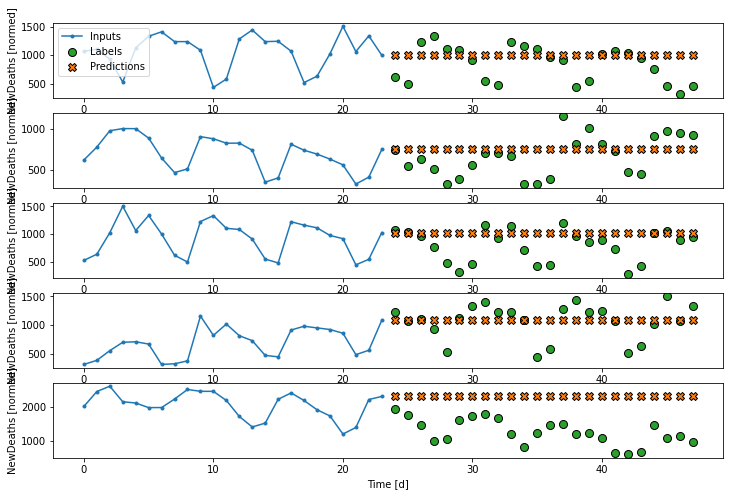

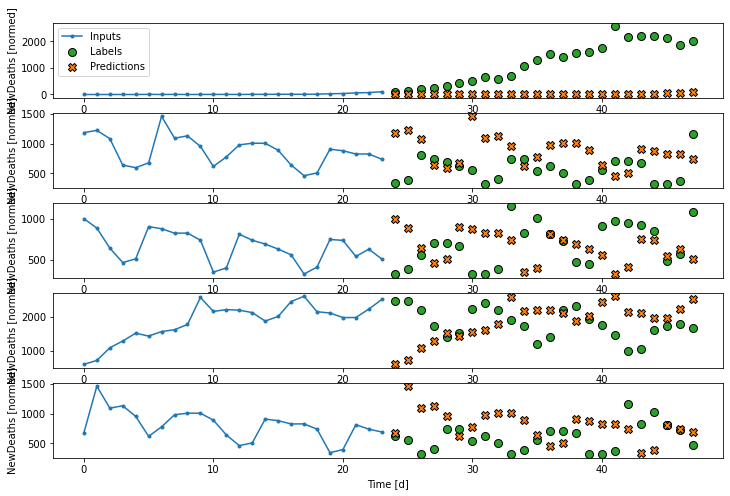

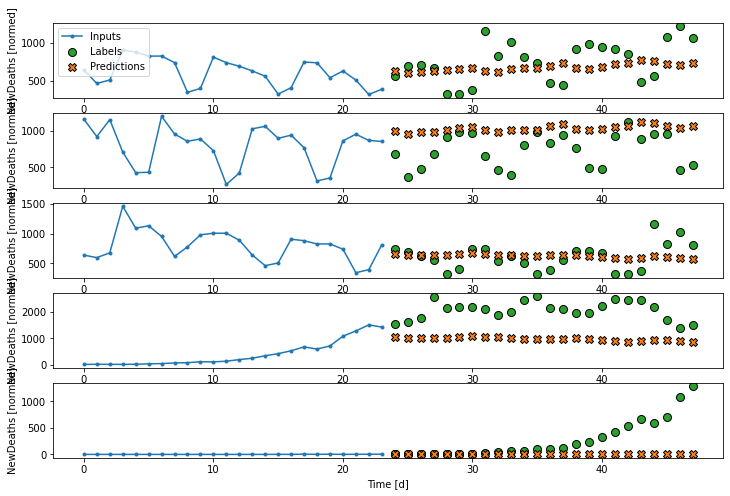

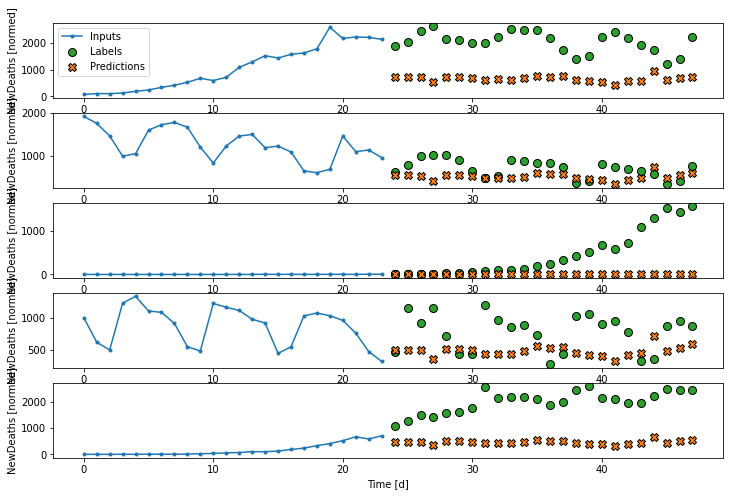

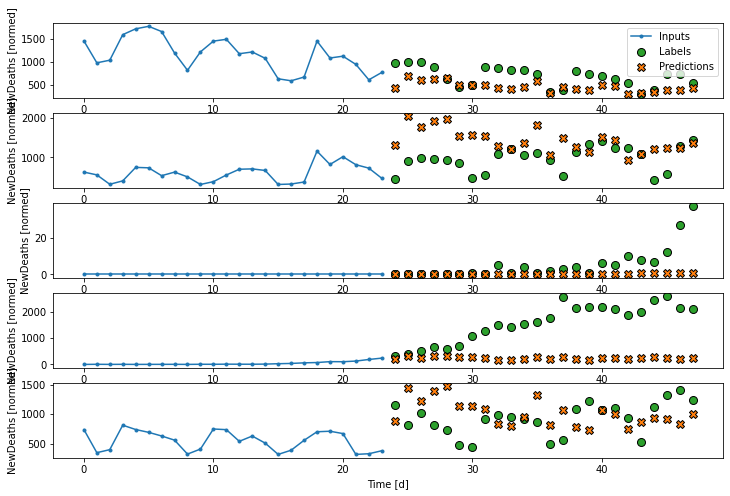

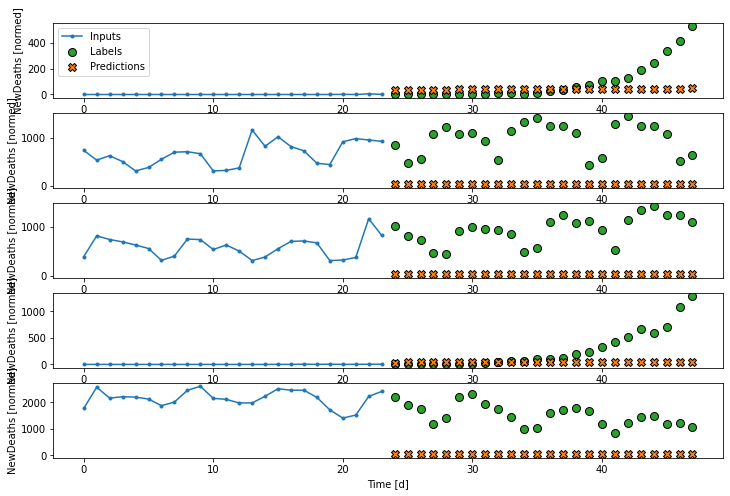

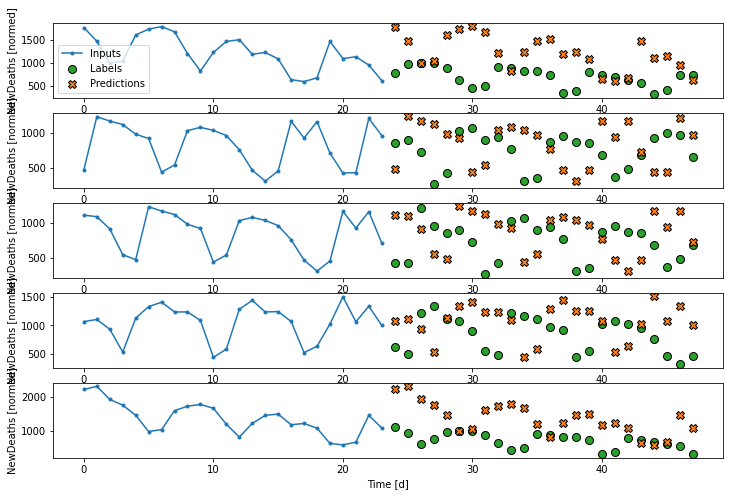

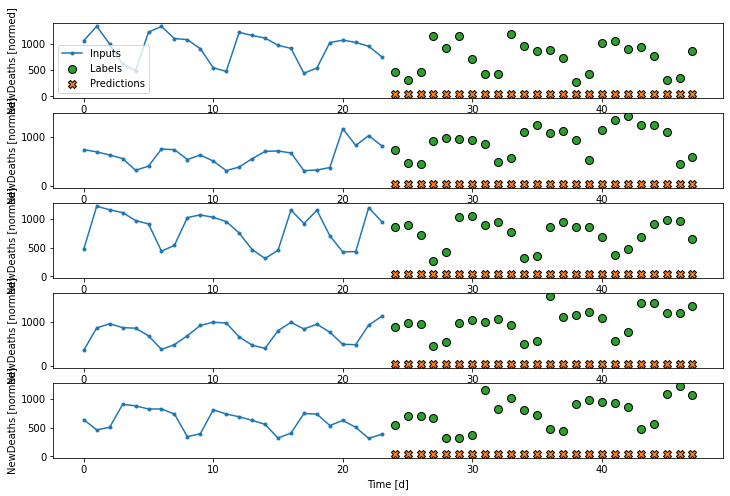

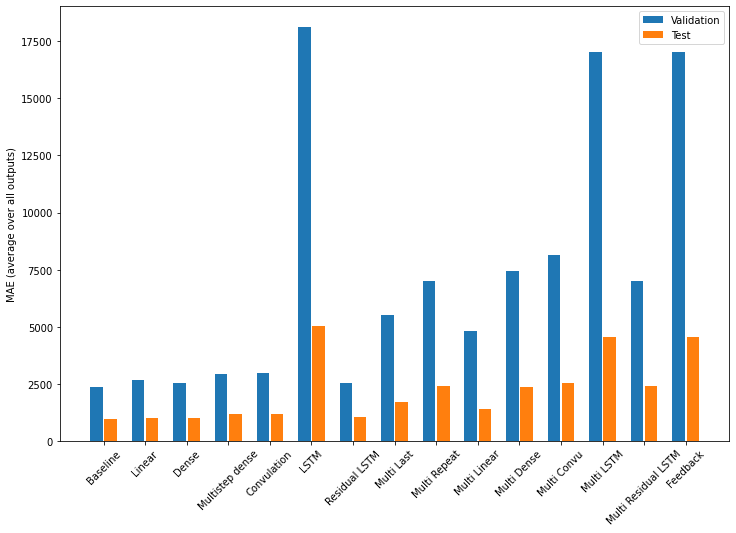

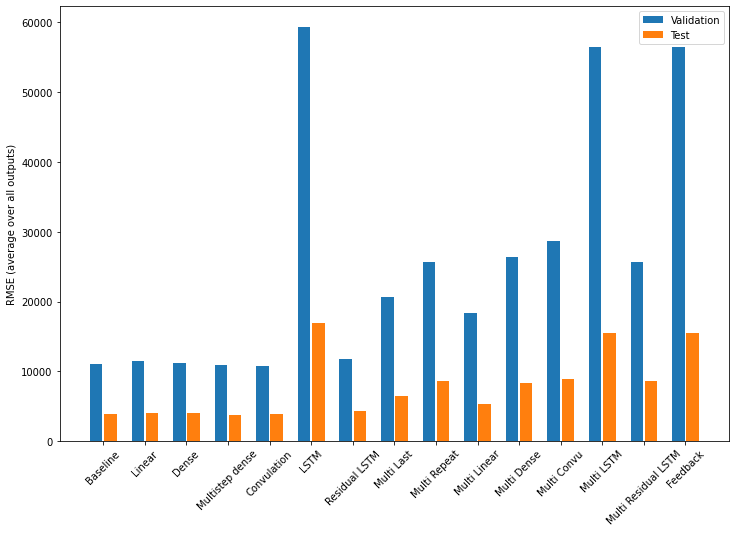

In [22]:
corona.evaluate_models()